# MIIII

In [1]:
import jax.numpy as jnp
from jax import random
import jax
from oeis import oeis
import optax
from functools import partial
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot as plt
import src

In [2]:
def predict(apply_fn, params, x, _=random.PRNGKey(0)):
    return (jax.nn.sigmoid(apply_fn(params, _, x, 0.0)) > 0.5).astype(jnp.int32)

In [3]:
# config and init
conf, (rng, key) = src.get_conf(), random.split(random.PRNGKey(0))

data = src.prime_fn(conf.n, partial(src.base_n, conf.base))
params = src.init_fn(key, conf)

In [4]:
# setup and train
apply_fn = src.make_apply_fn(src.vaswani_fn)
train_fn, opt_state = src.init_train(apply_fn, params, conf, *data)

(params, opt_state), losses = train_fn(conf.epochs, rng, (params, opt_state))

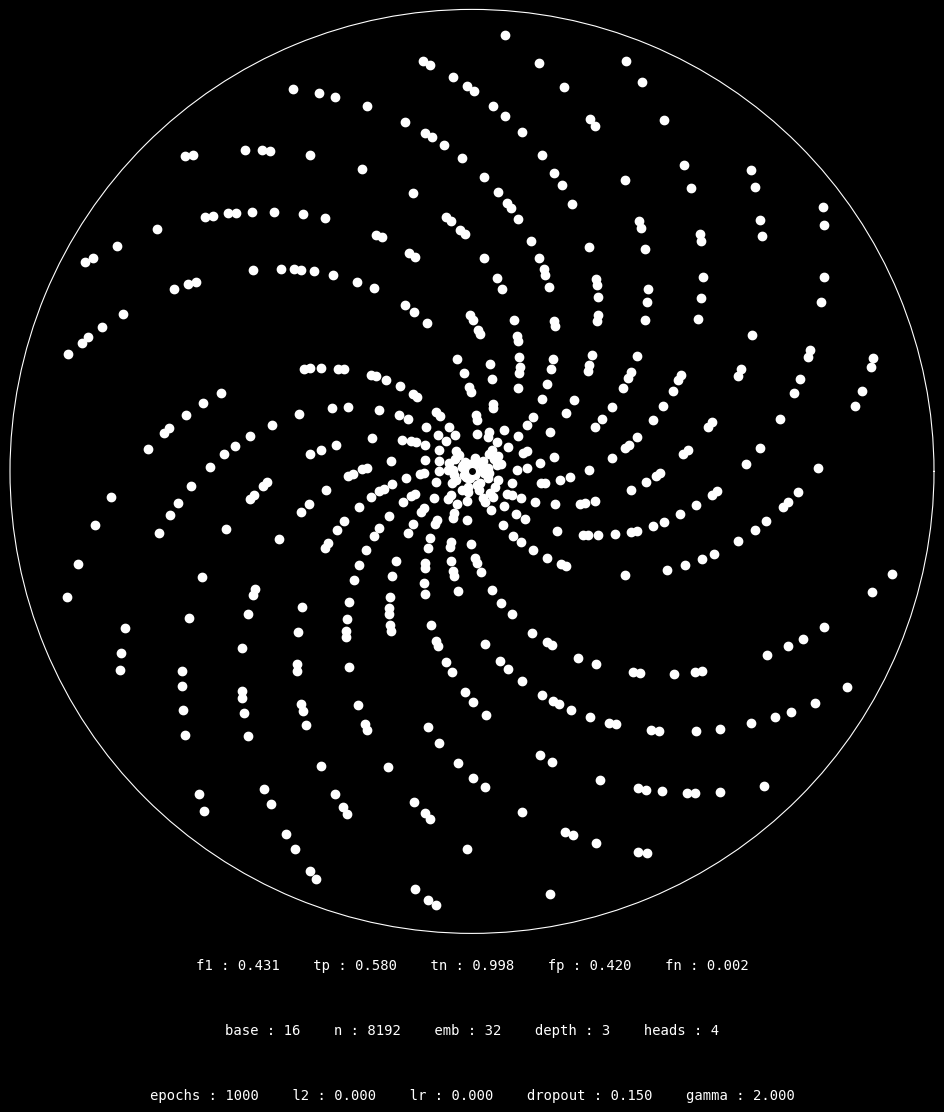

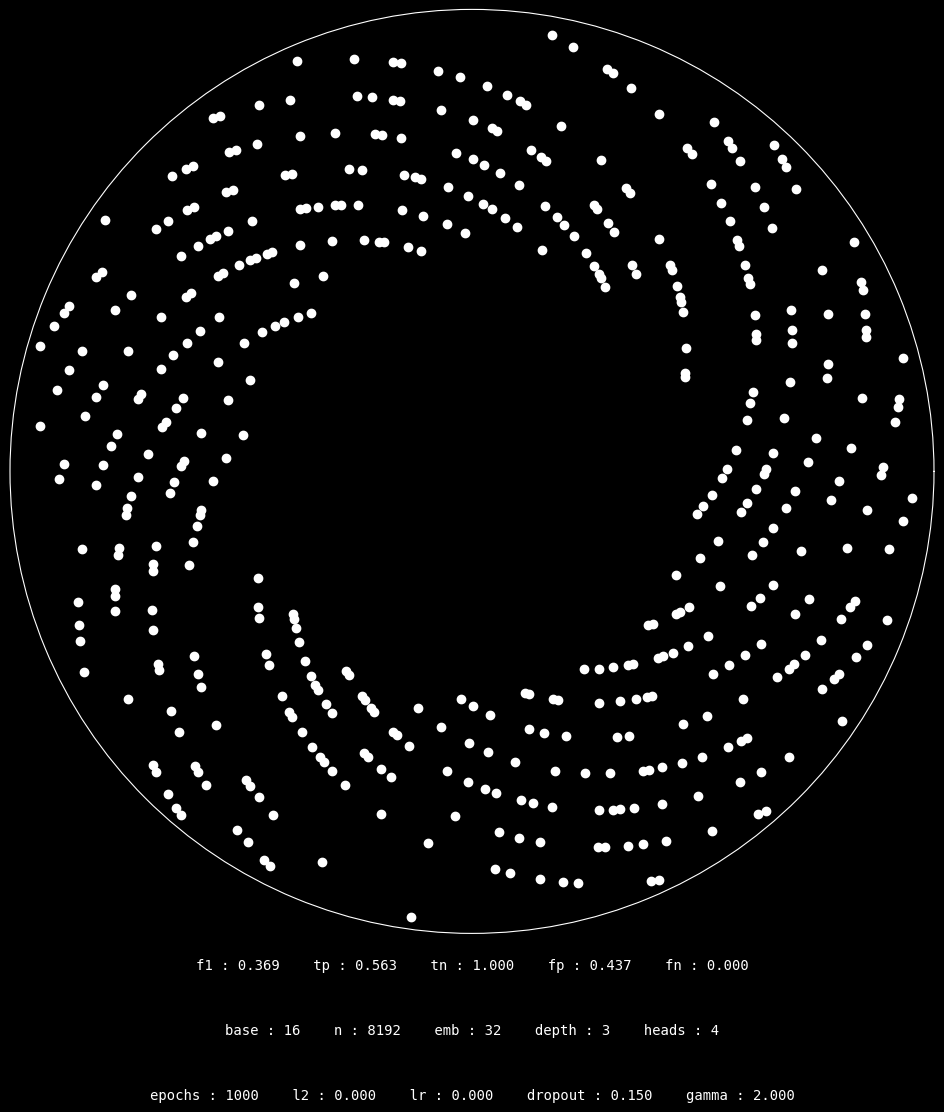

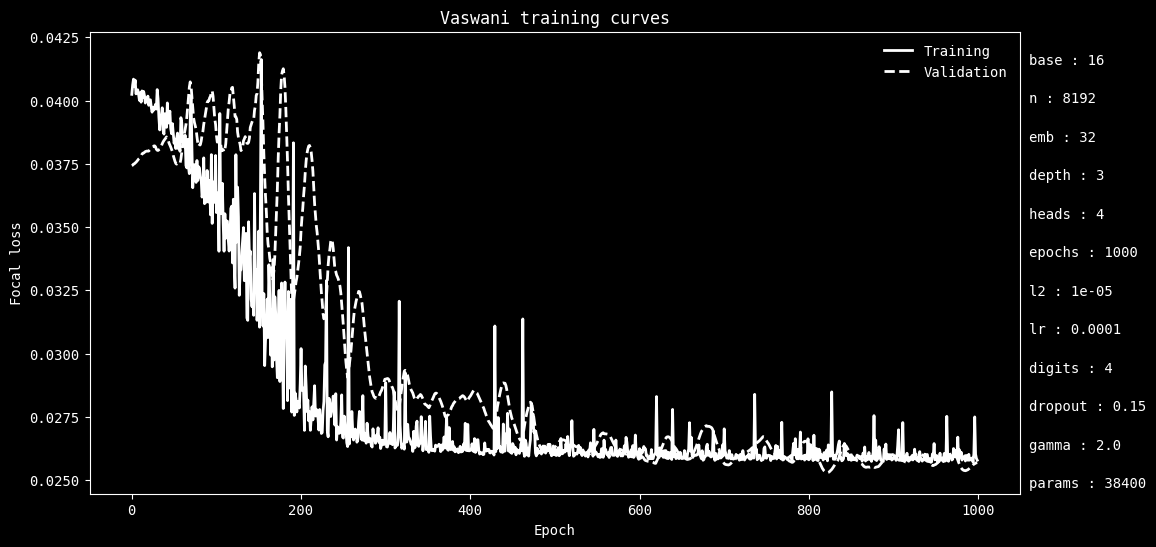

In [ ]:
# evaluate
def make_plots(losses, conf, params):
    (train_x, train_y), (valid_x, valid_y) = data
    train_pred = predict(apply_fn, params, train_x)
    valid_pred = predict(apply_fn, params, valid_x)
    src.polar_plot(train_y, train_pred, conf, "train")
    src.polar_plot(valid_y, valid_pred, conf, "valid", offset=train_y.shape[0])
    src.curve_plot(losses, conf, params)


make_plots(losses, conf, params)